<a href="https://colab.research.google.com/github/JoaoAreias/Artificial-intelligence/blob/master/Reinforcement%20Learning/Reinforcement_Learning_(Cross_entropy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por reforço
A aprendizagem por reforço é um método de apendizado não supervisionado que consiste em simular o ambiente e permitir que um agente interaja com o ambiente.

<center>![Fonte: Wikipédia](https://upload.wikimedia.org/wikipedia/commons/1/1b/Reinforcement_learning_diagram.svg)</center>

Este método busca recompensar atitudes positivas do agente no ambiente e penalizar atitudes negativas.

### O agente
O agente é o modelo para o qual esta se aplicando o algorítimo de aprendizagem sendo comumente utilizadas redes neurais para o processo. Este agente recebe as variáveis de estado que descrevem o ambiente e retornam a ação pela qual ele irá interagir com o ambiente.

Uma vez a ação é executada o agente se encontrará em um outro estado e receberá uma recompença pelo feito. O objetivo do agente é maximizar a recompensa total.

### Recompensa
A recompensa define o objetivo pelo qual o agente deve ser otimizado. O passo de definir quais serão as recompenças deve ser feito com cuidado pois uma definição errônea [pode levar a resultados não desejados](https://blog.openai.com/faulty-reward-functions/). Os problemas e as formas de evita-los fogem do escopo deste tutorial.

### Método da entropia cruzada

O método da entropia cruzada consiste na utilização do método de Monte Carlo para avaliar a importância de um estimador. O algorítimo por si, consiste na repetição de 2 passos:

- Colete amostras da distribuição estimada
- Minimize a [entropia cruzada](https://en.wikipedia.org/wiki/Cross_entropy) entre a distribuição desejada e a distribuição estimada para que uma estimativa melhor seja feita no próximo passo.

A aprendizagem por reforço busca representar o problema pelo processo de decisão de Markov onde a recompença esperada dada um estado depende apenas dos estados futuros. Para a aprendizagem por reforço nós buscamos modelar o processo de Markov que maximiza a recompença esperada.

## Setup

Vamos primeiro instalar algumas bibliotecas necessárias para a visualização.

In [1]:
!apt install -qq xvfb ffmpeg python-opengl -y

!pip install -q pyvirtualdisplay
!pip install -q piglet
!pip install -q gym


ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Selecting previously unselected package python-opengl.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 71kB 4.9MB/s 


Agora podemos importar alguns módulos que vamos usar durante este tutorial

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## O ambiente
Vamos começar primeiramente com o ambiente de simulação e o problema que queremos resolver. Para este caso vamos trabalhar com o controle de um pendulo invertido de forma a manter ele estável. Podemos agradecer a [OpenAi](https://openai.com/) por facilitar o nosso serviço disponibilizando um [ambiente para simulação](https://gym.openai.com/envs/CartPole-v1/).

Espaço de estados: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Possiveis ações: Discrete(2)


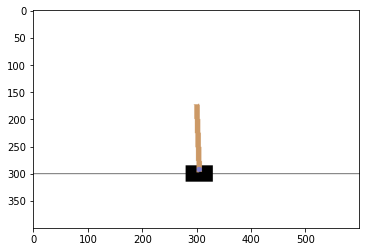

In [3]:
import gym
env = gym.make("CartPole-v1")
env.reset()
plt.imshow(env.render('rgb_array'))
print("Espaço de estados:", env.observation_space)
print("Possiveis ações:", env.action_space)

## O Modelo


O modelo deve ter como entrada os estados e como saída as ações, assim, usamos uma rede com 4 neurônios na entrada e 2 neurônios na saída.

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation

def make_model():
  model = Sequential()
  model.add(Dense(10, input_dim=4, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
  return model

In [5]:
model = make_model()

## A simulação

Agora podemos simular o ambiente para que possamos treinar a nossa rede neural. Primeiro criamos a função que irá realizar a simulação.

In [6]:
def generate_session(tmax=10000, training=True):
  states, actions = [], []
  total_reward = 0
  
  state = env.reset()
  for t in range(tmax):
    probs = model.predict(np.expand_dims(state, axis=0))
    
    if training:
        action = np.random.choice(2, p=np.ravel(probs))
    else:
        action = np.argmax(np.ravel(probs))

    new_s, r, done, _ = env.step(action)
    
    states.append(state)
    actions.append(action)
    total_reward += r - 0.1*np.abs(state[0])
    
    state = new_s
    if done:
      break
  return states, actions, total_reward
  

Queremos então selecionar quais simulações tiveram a melhor recompensa.

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
  reward_threshold = np.percentile(rewards_batch, percentile)
  
  elite_states  = np.vstack(states_batch[rewards_batch >= reward_threshold])
  elite_actions = np.hstack(actions_batch[rewards_batch >= reward_threshold])
  
  return elite_states, elite_actions

Por último queremos ver o resultado do treinamento, assim, utilizei o código apresentado [aqui](https://github.com/yandexdataschool/Practical_RL), desenvolvido para o curso [Practical Reinforcement Learning](https://www.coursera.org/learn/practical-rl).

In [8]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

## Treinamento

Podemos agora treinar o nosso modelo e conferir os resultados, para isso selecionaremos os melhores jogos e treinaremos a rede para mapear os estados apresentados para as ações tomadas.

mean reward = 496.225, threshold=497.027


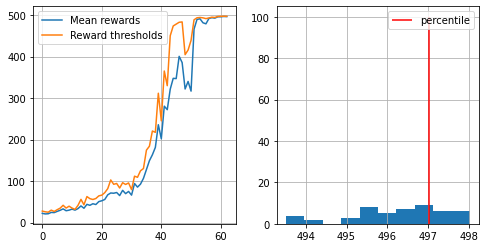

 14%|█▍        | 7/50 [02:14<13:44, 19.17s/it]

In [ ]:
from tensorflow.keras.utils import to_categorical

n_sessions = 50
percentile = 75
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session(tmax=int(1e7), training=True) for _ in tqdm.trange(n_sessions)]
    
    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
    
    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards, percentile=percentile)
    model.fit(elite_states, to_categorical(elite_actions))
    show_progress(batch_rewards, log, percentile, reward_range=[np.min(batch_rewards), np.max(batch_rewards)])
    
    model.save('./inverted_pendulum.h5')
    
    if np.mean(batch_rewards) > 499:
      print("Training complete")
      break

## Resultados

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v1"), directory="videos", force=True)
sessions = [generate_session(int(1e5), training=False) for _ in range(100)]
env.close()

In [ ]:
from google.colab import files
import os

video_names = list(filter(lambda s:s.endswith(".mp4"), os.listdir("./videos/")))
files.download('./videos/'+video_names[-1])

In [ ]:
!ls videos